In [19]:
# %pip install -r requirements.txt


Importing required packages


In [40]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import os
import math
import soundfile as  sf

Importing audio 

In [21]:
audio, sr = librosa.load('Misirlou.wav', sr=16000)

In [22]:
spectrogram = librosa.stft(audio, n_fft=2048, hop_length=256, center=False, win_length=2048)
M = abs(spectrogram)
phase = spectrogram/(M + 2.2204e-16)
M.shape

(1025, 1978)

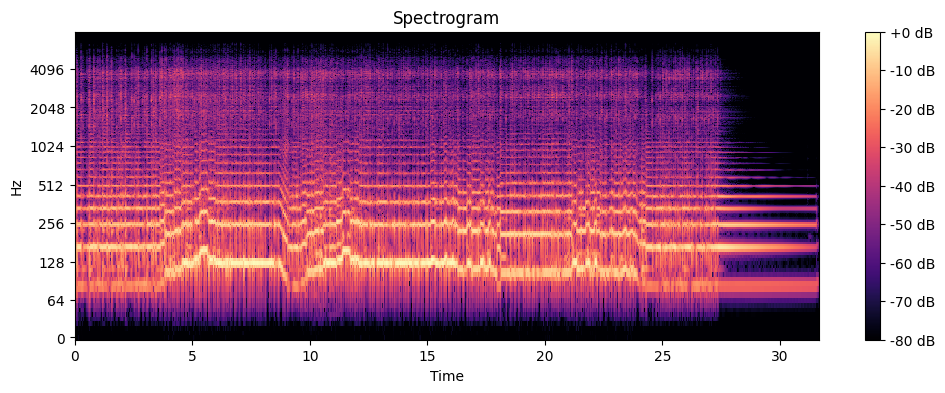

In [23]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(M, ref=np.max),
                         sr=sr, hop_length=256, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

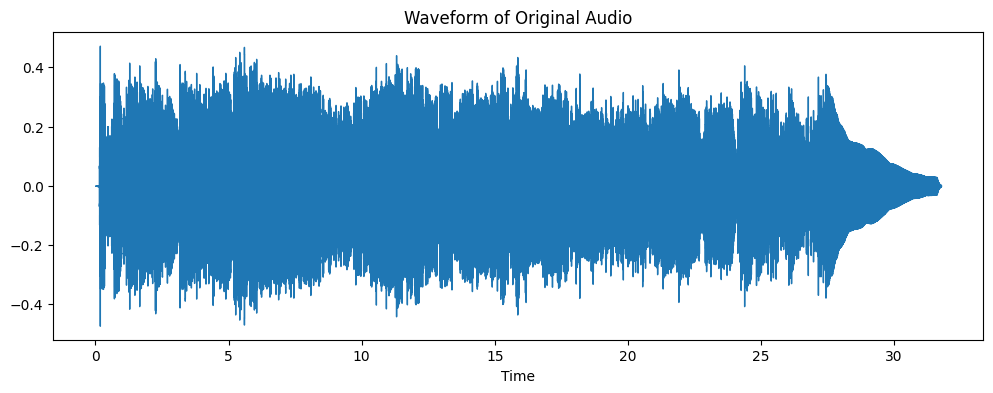

In [24]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title('Waveform of Original Audio')
plt.show()

Define a function that normalises each individual note from the notes folder

In [25]:
def process_note(note_file):
    note_audio, _ = librosa.load(note_file, sr=16000)
    note_spectrogram = librosa.stft(note_audio, n_fft=2048, hop_length=256, center=False, win_length=2048)
    n = np.abs(note_spectrogram)

    middle_column_index = int(math.ceil(n.shape[1] / 2))
    middle = n[:, middle_column_index]
    
    middle[middle < (max(middle) / 100)] = 0
    middle = middle / np.linalg.norm(middle)

    return middle


In [28]:
notes_path = 'notes_scale'
note_files = sorted([os.path.join(notes_path, f) for f in os.listdir(notes_path) if f.endswith('.wav')])

N = np.column_stack([process_note(note_file) for note_file in note_files])
plt.figure(figsize=(12, len(note_files) * 3))
N.shape

(1025, 7)

<Figure size 1200x2100 with 0 Axes>

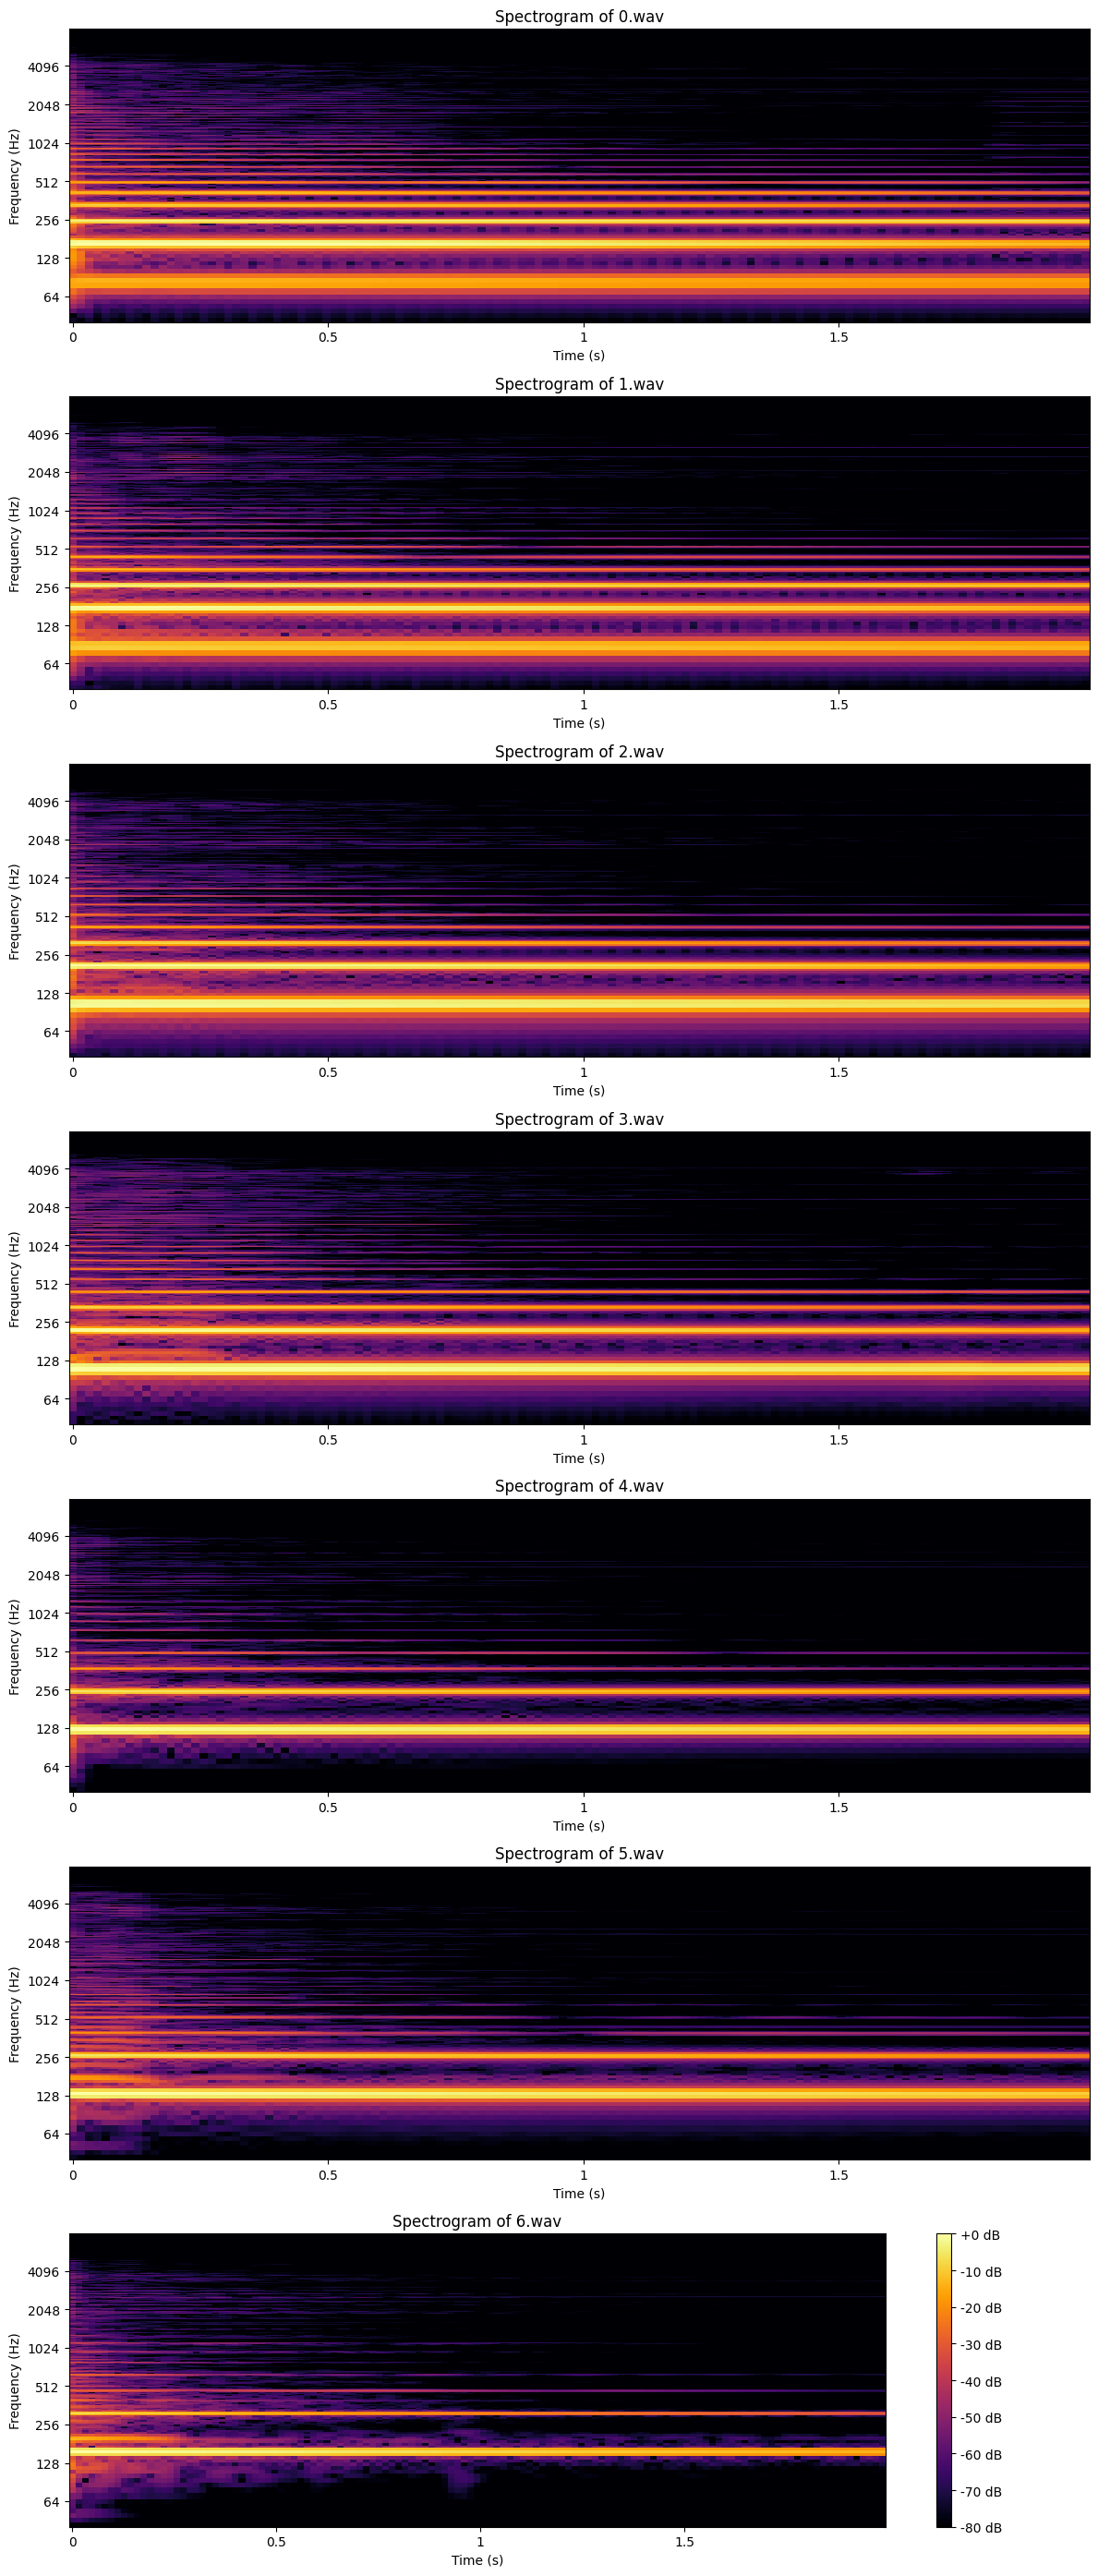

In [36]:
plt.figure(figsize=(12, len(note_files) * 4))

for i, note_file in enumerate(note_files):
    audio, sr = librosa.load(note_file, sr=16000)

    # Compute the spectrogram using STFT
    spectrogram = librosa.stft(audio, n_fft=2048, hop_length=256, center=False, win_length=2048)
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)

    # Plot the spectrogram
    plt.subplot(len(note_files), 1, i + 1)
    librosa.display.specshow(spectrogram_db, sr=sr, hop_length=256, x_axis='time', y_axis='log', cmap='inferno')
    
    # Add a title for each subplot
    plt.title(f'Spectrogram of {os.path.basename(note_file)}', fontsize=12)
    
    # Add axis labels for time and frequency
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    
    # Adjust the frequency range to match the example image
    plt.ylim([20, 8000])

    # Only display the colorbar on the last plot for clarity
    if i == len(note_files) - 1:
        plt.colorbar(format='%+2.0f dB')

# Add spacing between the subplots
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()

# Show the final figure
plt.show()

In [37]:
W, _, _, _ = np.linalg.lstsq(N, M, rcond=None)

# Save W to CSV
np.savetxt('problem1.csv', W, delimiter=',')

In [38]:
# Step 7: Set negative elements in W to zero
W[W < 0] = 0

# Step 8: Recompute M_hat
M_cap = np.dot(N, W)

# Step 9: Compute the error ||M - M_cap||^2_F
error = np.sum((M - M_cap) ** 2)
print(f'Reconstruction error: {error}')


Reconstruction error: 4279084.0


In [41]:
# Step 10: Recover the signal from the reconstructed spectrogram M_hat
signal_hat = librosa.istft(M_cap * phase, hop_length=256, center=False, win_length=2048)

# Step 11: Write the signal to a wav file
sf.write('resynthesized_proj.wav', signal_hat, 16000)

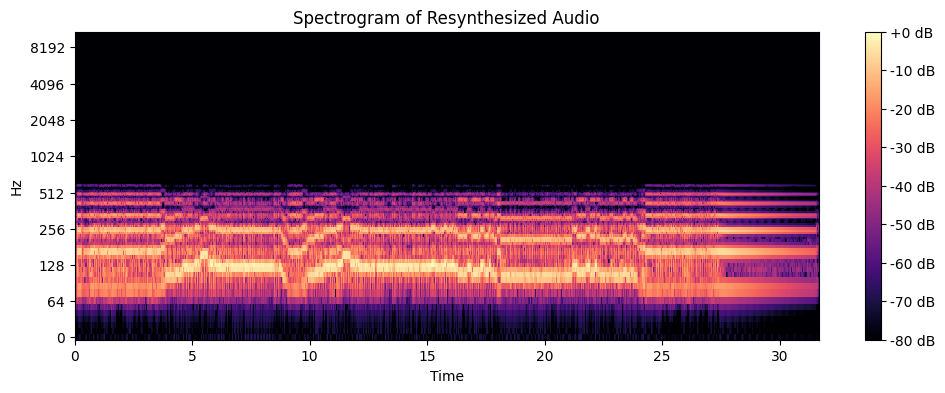

In [52]:
# Load the resynthesized audio file
audio_cap, sr = librosa.load('resynthesized_proj.wav')

# Compute the spectrogram of the resynthesized audio
spectrogram_cap = librosa.stft(audio_cap, n_fft=2048, hop_length=256, center=False, win_length=2048)
M_cap = np.abs(spectrogram_cap)

# Convert to decibels for visualization
M_cap_db = librosa.amplitude_to_db(M_cap, ref=np.max)

# Display the spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(M_cap_db, sr=sr, hop_length=256, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Resynthesized Audio')
plt.show()

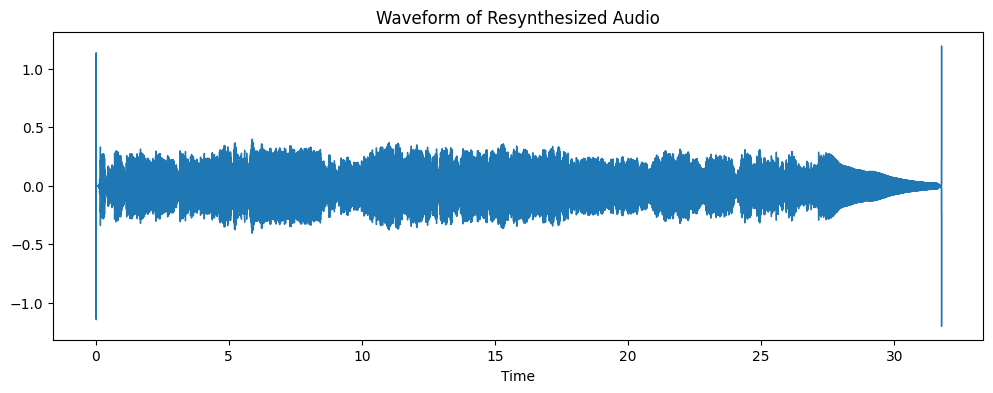

In [44]:
# You can also plot the waveform of the resynthesized audio
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio_cap, sr=sr)
plt.title('Waveform of Resynthesized Audio')
plt.show()

In [45]:
etas = [100, 1000, 10000, 100000]
iterations = 1000
best_eta = None
lowest_error = float('inf')
best_W = None

In [46]:
D, T = M.shape
K = N.shape[1]
W = np.zeros((K, T))

In [48]:
def compute_error(M, N, W):
    return np.linalg.norm(M - np.dot(N, W), 'fro')**2 / (D * T)

In [49]:
errors = {}

for eta in etas:
    W_n = np.zeros((K, T))  
    error_history = []
    
    for n in range(iterations):
        gradient = -2 / (D * T) * np.dot(N.T, (M - np.dot(N, W_n)))
        W_n = W_n - eta * gradient
   
        W_n = np.maximum(W_n, 0)
    
        error = compute_error(M, N, W_n)
        error_history.append(error)

    errors[eta] = error_history

    if error < lowest_error:
        lowest_error = error
        best_W = W_n
        best_eta = eta

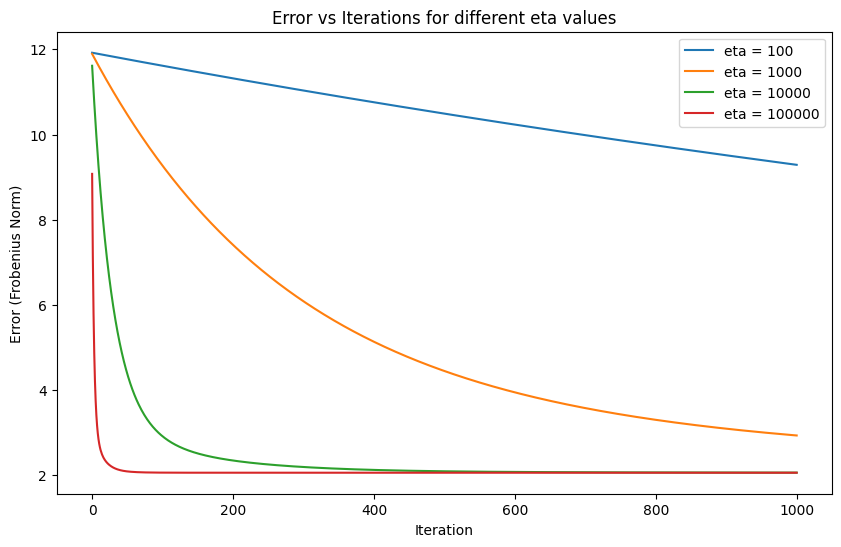

In [50]:
plt.figure(figsize=(10, 6))
for eta in etas:
    plt.plot(errors[eta], label=f'eta = {eta}')
plt.xlabel('Iteration')
plt.ylabel('Error (Frobenius Norm)')
plt.title('Error vs Iterations for different eta values')
plt.legend()
plt.show()


In [51]:
np.savetxt('problem2W.csv', best_W, delimiter=',')

M_cap = np.dot(N, best_W)

signal_hat = librosa.istft(M_cap * phase, hop_length=256, center=False, win_length=2048)
sf.write('resynthesized_nnproj.wav', signal_hat, 16000)

final_error = compute_error(M, N, best_W)
print(f'Final reconstruction error: {final_error}')


Final reconstruction error: 2.0578206163984842


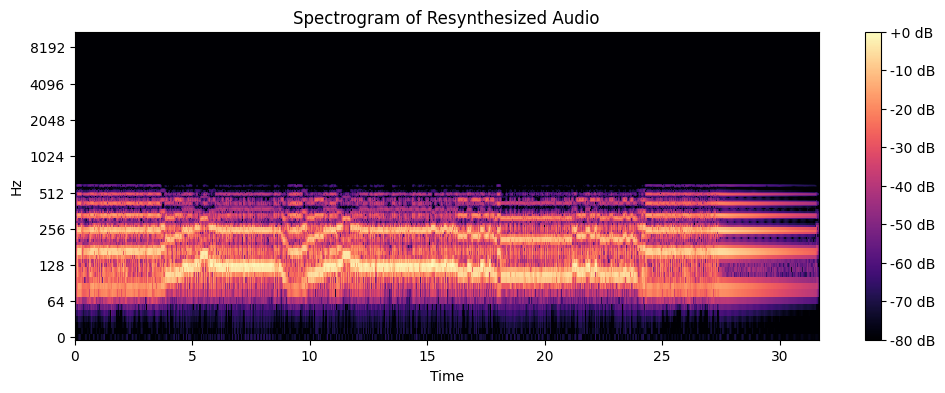

In [53]:
# Visualising The New Audio
# Load the resynthesized audio file
audio_cap1, sr = librosa.load('resynthesized_nnproj.wav')

# Compute the spectrogram of the resynthesized audio
spectrogram_cap1 = librosa.stft(audio_cap1, n_fft=2048, hop_length=256, center=False, win_length=2048)
M_cap1 = np.abs(spectrogram_cap1)

# Convert to decibels for visualization
M_cap1_db = librosa.amplitude_to_db(M_cap1, ref=np.max)

# Display the spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(M_cap1_db, sr=sr, hop_length=256, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Resynthesized Audio')
plt.show()

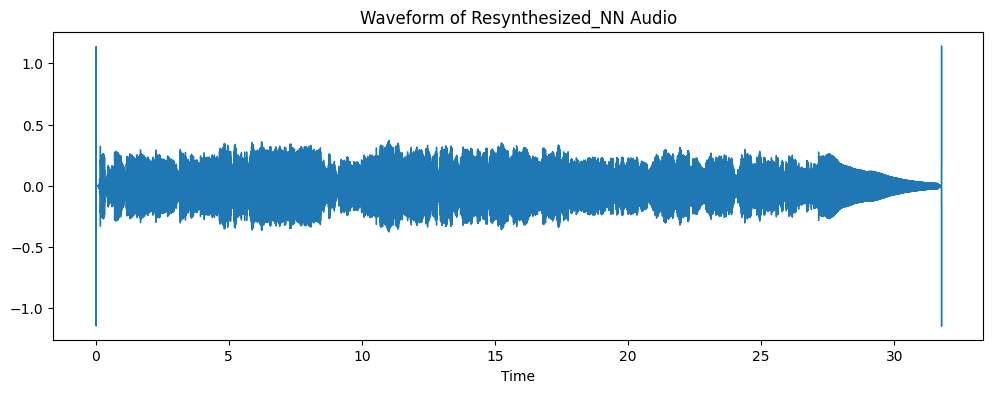

In [54]:
# You can also plot the waveform of the resynthesized audio
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio_cap1, sr=sr)
plt.title('Waveform of Resynthesized_NN Audio')
plt.show()